In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')


In [22]:
df = pd.read_csv("Flight_Data_Final.csv")

x = pd.concat([df.iloc[:, 1:3], df.iloc[:,4:]], axis = 1)
y = pd.DataFrame(df.iloc[:, 3])


## Correlation between features


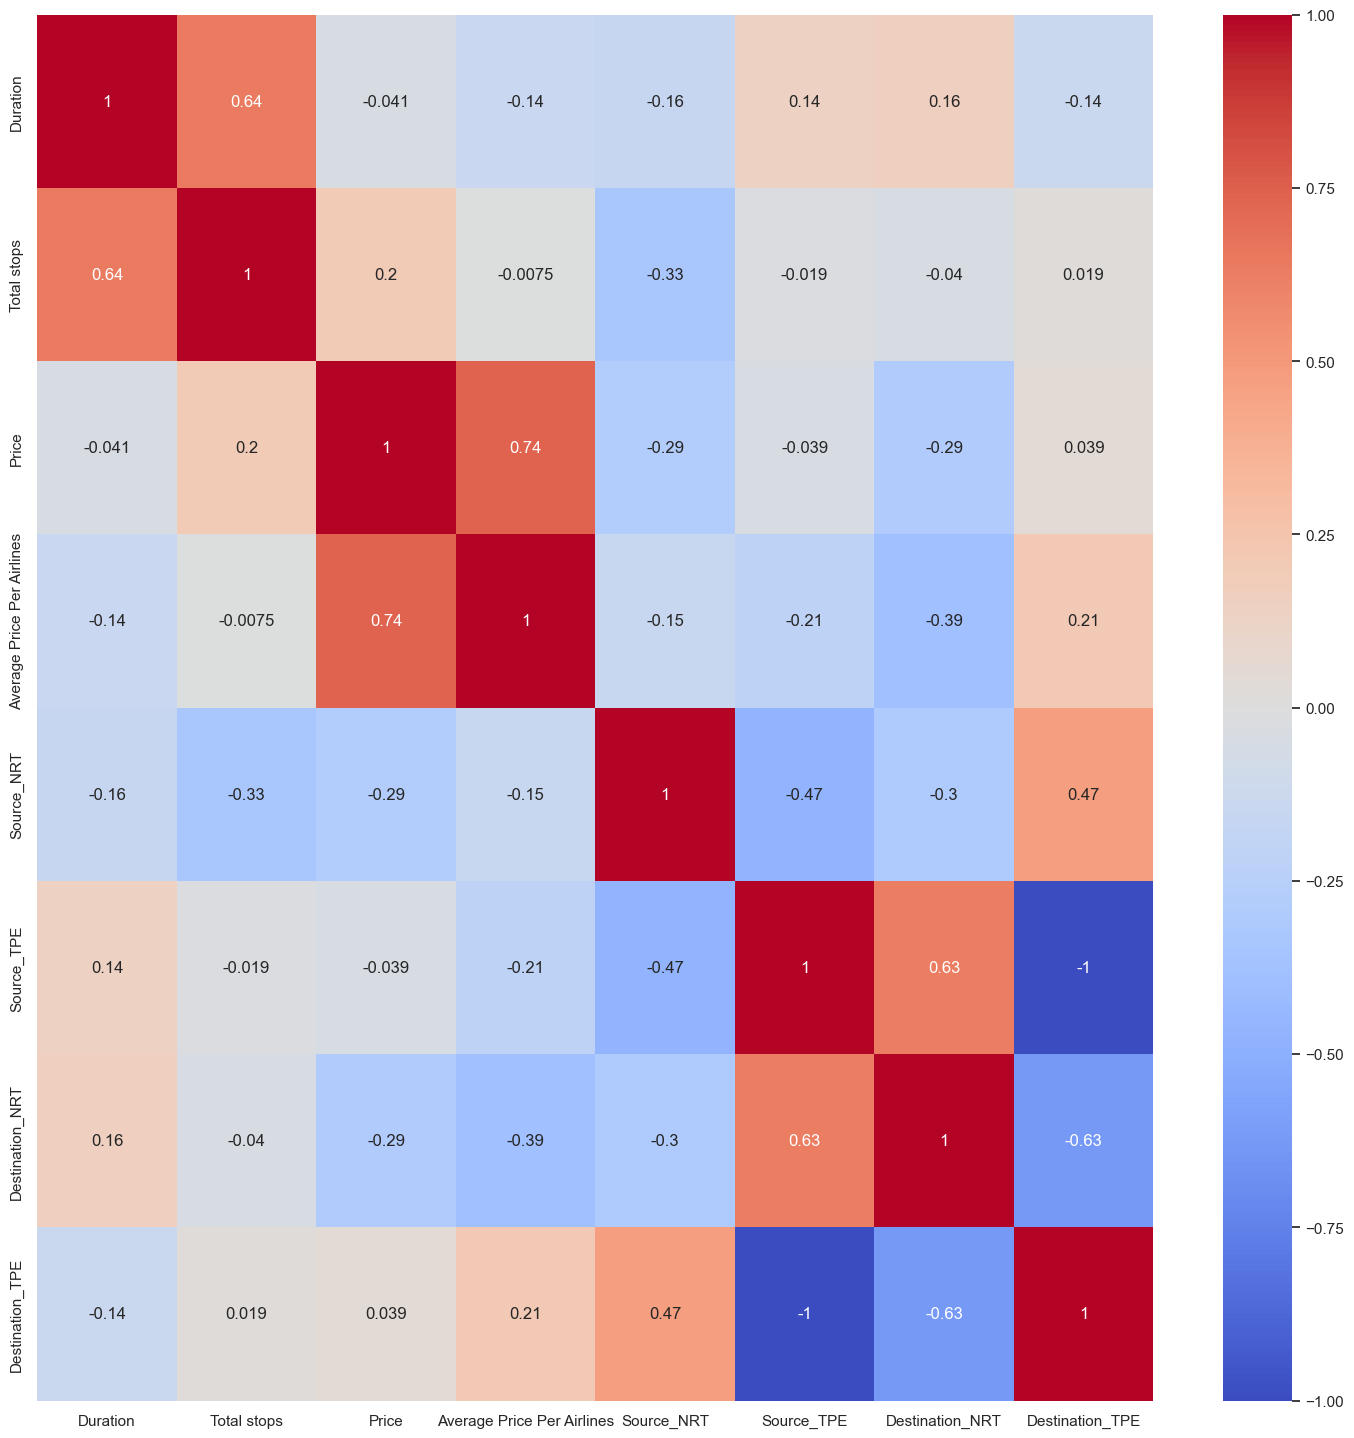

In [24]:
df = df.drop(['index'], axis = 1)

plt.figure(figsize = (18,18))

sns.heatmap(df.corr(),annot= True, cmap = "coolwarm")

plt.show()

## Splitting the dataset to the training, validating, and testing set

In [25]:
from sklearn.model_selection import train_test_split

# train-val-test: 70-15-15
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size = 0.3, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, random_state = 1) 
x_train_val = pd.concat([x_train, x_val])
y_train_val = pd.concat([y_train, y_val])

## Feature Scaling

Because not all model need feature scaling, I created an additional dataset for scaled data.

`x_train` and `y_train` are the trining set of data without feature scaling.

`x_train_sc` and `y_train_sc` are the training set of data with feature scaling.

Remember to transform the scaled data to the original scale when predicting.

In [26]:
x_train_sc, x_val_sc, x_test_sc = x_train.copy(), x_val.copy(), x_test.copy()
y_train_sc, y_val_sc, y_test_sc = y_train.copy(), y_val.copy(), y_test.copy()
# Import the class for Standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc_y = StandardScaler()

# Fit the feature scaling object onto training set
x_train_sc = sc.fit_transform(x_train.values)
y_train_sc = sc_y.fit_transform(y_train.values)


# Fit the feature scaling object onto validating set
x_val_sc = sc.transform(x_val.values) 
y_val_sc = sc_y.fit_transform(y_val.values)

# Fit the feature scaling object onto testing set by "mean and std" of train set !!!!!!
# Don't fit train set on its own
x_test_sc  = sc.transform(x_test.values)
y_test_sc = sc_y.fit_transform(y_test.values)

## Feature Importance

In [27]:
# getting feature importance to the target variable "Price"
selection = ExtraTreesRegressor()
selection.fit(x, y)

feature_importance = pd.DataFrame({'feature' : x.columns, 'importance' :  selection.feature_importances_})
feature_importance

,feature,importance
0,Duration,0.113455
1,Total stops,0.037158
2,Average Price Per Airlines,0.726807
3,Source_NRT,0.048341
4,Source_TPE,0.020473
5,Destination_NRT,0.034545
6,Destination_TPE,0.019221


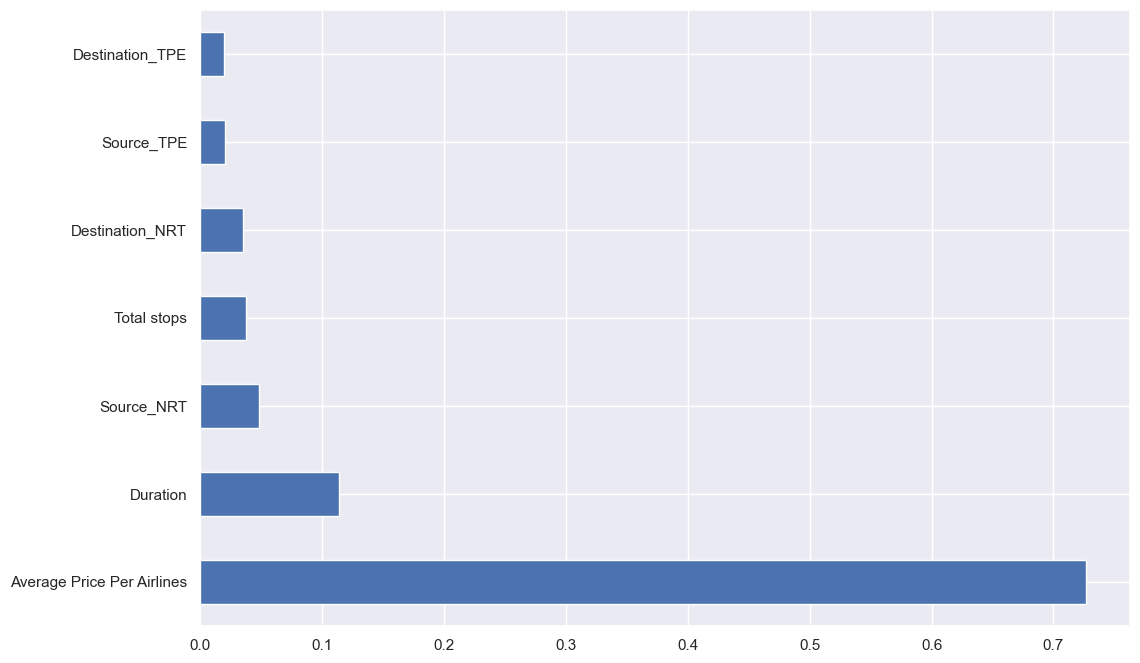

In [28]:
# plotting graph of important features
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_,index = x.columns)
feat_importances.nlargest(20).plot(kind="barh")
plt.show()

In [29]:
def get_metrics(model):
    print(f'Train score {model.score(x_train, y_train)}')
    print(f'Val score {model.score(x_val, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(x_val)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(x_val)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(x_val))))
    
def get_metrics_scaled(model):
    print(f'Train score {model.score(x_train_sc, y_train_sc)}')
    print(f'Val score {model.score(x_val_sc, y_val_sc)}')
    print("MAE:" , metrics.mean_absolute_error(y_val_sc,model.predict(x_val_sc)))
    print("MSE:" , metrics.mean_squared_error(y_val_sc,model.predict(x_val_sc)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val_sc,model.predict(x_val_sc))))

## Modelling

### Linear Regression

Train score 0.6181339778787092
Val score 0.6362815095939676
MAE: 42.04231724743035
MSE: 2880.39459488435
RMSE: 53.66930775484579


Text(0, 0.5, 'Actual Airline Prices')

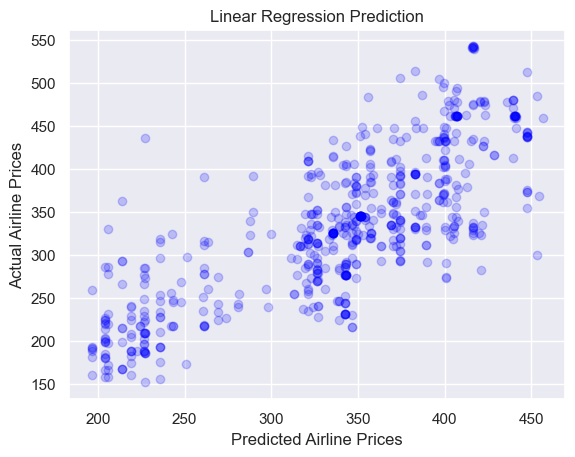

In [30]:
lr = LinearRegression()
lr.fit(x_train, y_train)
score = lr.score(x_val, y_val)
get_metrics(lr)
plt.scatter(lr.predict(x_test), y_test, color = 'blue', alpha = 0.2)
plt.title('Linear Regression Prediction')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices')

### Polynomial Regression

--------------------
Degree 1
Train score 0.6181339778787092
Val score 0.6362815095939649
MAE: 42.04231724743103
MSE: 2880.394594884371
RMSE: 53.66930775484598


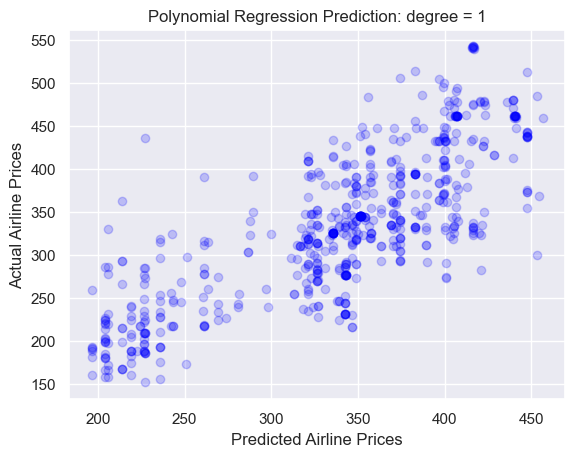

--------------------
Degree 2
Train score 0.6458671531758481
Val score 0.6715194510420459
MAE: 38.918948196224356
MSE: 2601.334885908354
RMSE: 51.00328308950664


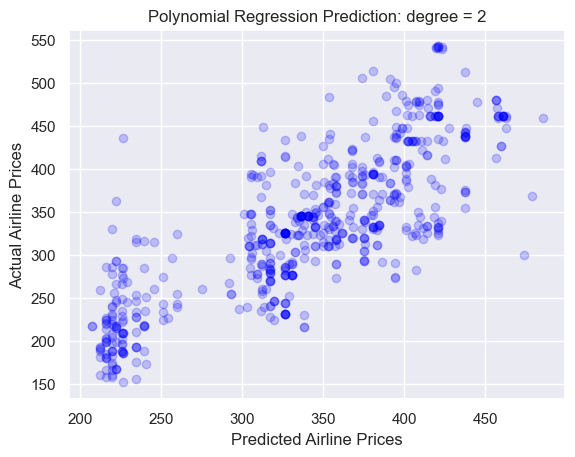

--------------------
Degree 3
Train score 0.6692579974388512
Val score 0.6882387155879437
MAE: 37.98268267935801
MSE: 2468.930071474299
RMSE: 49.68832932866931


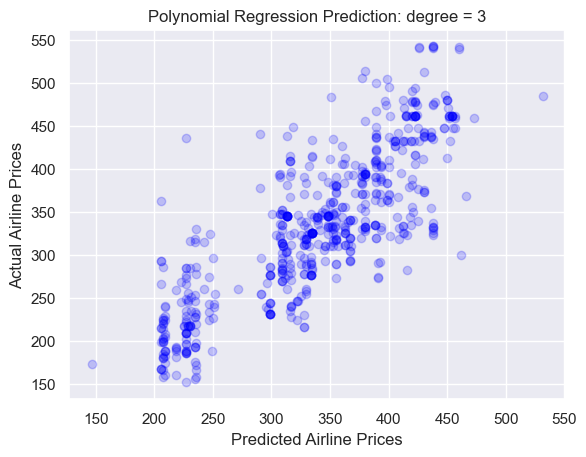

--------------------
Degree 4
Train score 0.6883541878270969
Val score -192.53232903499347
MAE: 85.94024843195493
MSE: 1532639.9102379242
RMSE: 1237.9983482371551


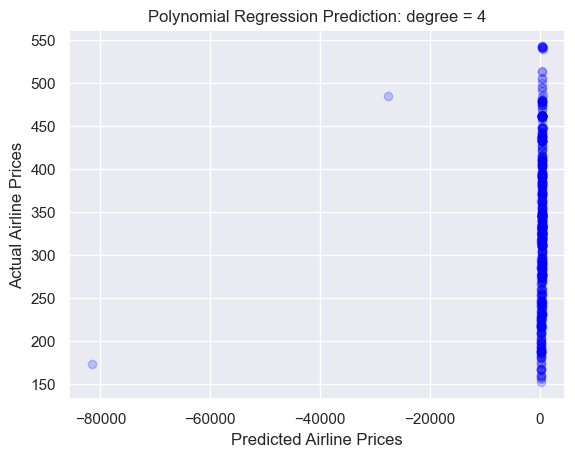

--------------------
Degree 5
Train score 0.7027348233541224
Val score -51098.913689773675
MAE: 844.7842441379996
MSE: 404675371.40267354
RMSE: 20116.544718282847


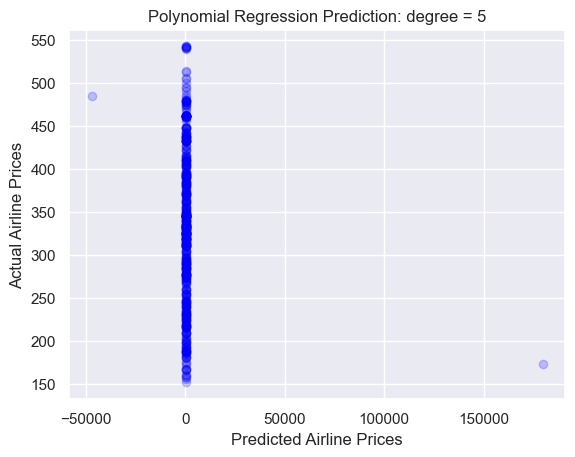

In [31]:
for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(x_train, y_train)
    print("-"*20)
    print("Degree", degree)
    get_metrics(poly)
    plt.scatter(poly.predict(x_test), y_test, color = 'blue', alpha = 0.2)
    plt.title(f'Polynomial Regression Prediction: degree = {degree}')
    plt.xlabel('Predicted Airline Prices')
    plt.ylabel('Actual Airline Prices')
    plt.show()
    

### Lasso

In [32]:
lasso_model = Lasso()
lasso_model.fit(x_train, y_train)
get_metrics(lasso_model)

Train score 0.6137658922390528
Val score 0.6342297711736353
MAE: 42.336705204506025
MSE: 2896.6429199267322
RMSE: 53.82046933952483


Text(0, 0.5, 'Actual Airline Prices')

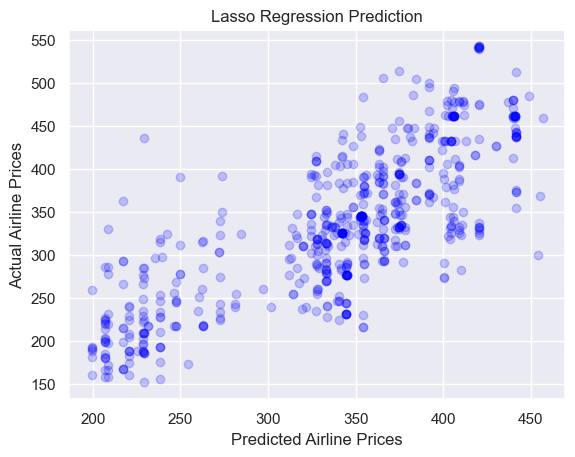

In [33]:
plt.scatter(lasso_model.predict(x_test), y_test, color = 'blue', alpha = 0.2)
plt.title('Lasso Regression Prediction')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices')

### Ridge Regression

In [34]:
ridge_model = Ridge()
ridge_model.fit(x_train, y_train)
get_metrics(ridge_model)

Train score 0.6181336198547425
Val score 0.6362915856561965
MAE: 42.04586245420399
MSE: 2880.3147995592644
RMSE: 53.668564351576094


Text(0, 0.5, 'Actual Airline Prices')

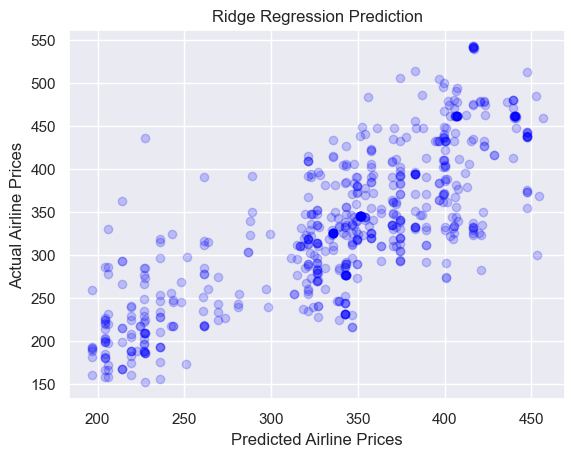

In [35]:
plt.scatter(ridge_model.predict(x_test), y_test, color = 'blue', alpha = 0.2)
plt.title('Ridge Regression Prediction')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices')

### Support Vector Machine

In [36]:
from sklearn.svm import SVR

# Use scaled features

SVR_regression = SVR(kernel = 'rbf')
SVR_regression.fit(x_train_sc, y_train_sc)
get_metrics_scaled(SVR_regression)

Train score 0.6554412017185628
Val score 0.6761062768705324
MAE: 0.41243864602425445
MSE: 0.32389372312946757
RMSE: 0.5691166164587602


Text(0, 0.5, 'Actual Airline Prices')

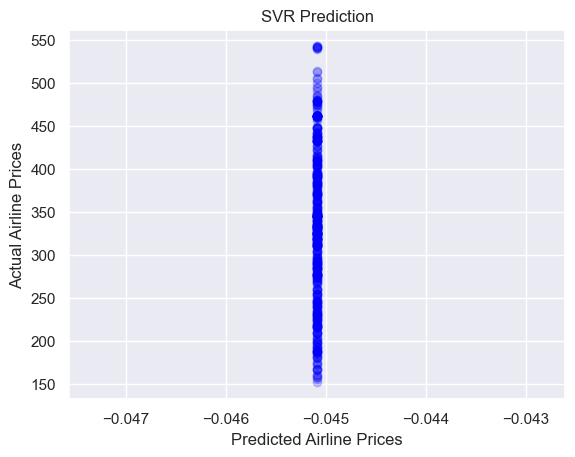

In [37]:
plt.scatter(SVR_regression.predict(x_test), y_test, color = 'blue', alpha = 0.2)
plt.title('SVR Prediction')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices')

### Decision Tree Regression

In [38]:
Decision_tree = DecisionTreeRegressor(random_state = 1)
Decision_tree.fit(x_train, y_train)
get_metrics(Decision_tree)

Train score 0.7775448581648607
Val score 0.7716233295965832
MAE: 30.525770790965097
MSE: 1808.5825834516784
RMSE: 42.527433304299926


Text(0, 0.5, 'Actual Airline Prices')

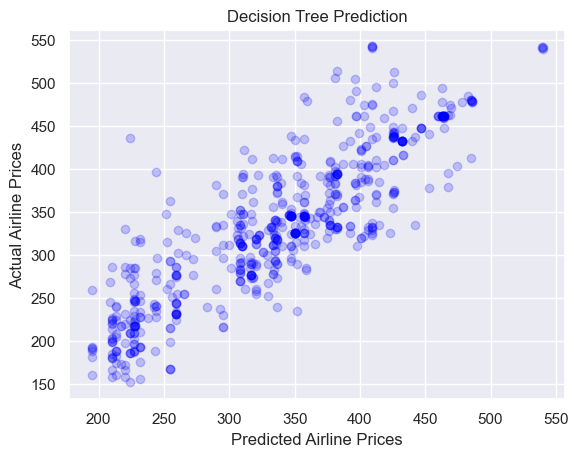

In [39]:
plt.scatter(Decision_tree.predict(x_test), y_test, color = 'blue', alpha = 0.2)
plt.title('Decision Tree Prediction')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices')

### Random Forests

In [40]:
Random_Forest = RandomForestRegressor(random_state = 1, n_estimators = 100)
Random_Forest.fit(x_train, y_train)
get_metrics(Random_Forest)

Train score 0.775291825375477
Val score 0.7876189389702029
MAE: 29.921031009060588
MSE: 1681.908608944026
RMSE: 41.01107909997036


Text(0, 0.5, 'Actual Airline Prices')

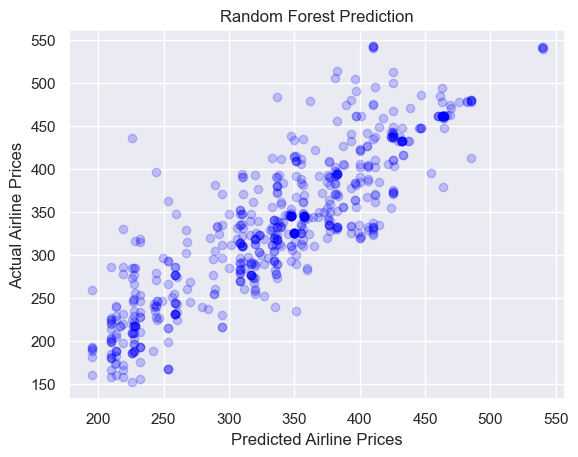

In [41]:
plt.scatter(Random_Forest.predict(x_test), y_test, color = 'blue', alpha = 0.2)
plt.title('Random Forest Prediction')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices')

In [42]:
# We screened out polynomial and SVR model first.
for model in [lr, lasso_model, ridge_model, Decision_tree, Random_Forest ]:
    print(str(model))
    get_metrics(model)
    print('----------------------------')


LinearRegression()
Train score 0.6181339778787092
Val score 0.6362815095939676
MAE: 42.04231724743035
MSE: 2880.39459488435
RMSE: 53.66930775484579
----------------------------
Lasso()
Train score 0.6137658922390528
Val score 0.6342297711736353
MAE: 42.336705204506025
MSE: 2896.6429199267322
RMSE: 53.82046933952483
----------------------------
Ridge()
Train score 0.6181336198547425
Val score 0.6362915856561965
MAE: 42.04586245420399
MSE: 2880.3147995592644
RMSE: 53.668564351576094
----------------------------
DecisionTreeRegressor(random_state=1)
Train score 0.7775448581648607
Val score 0.7716233295965832
MAE: 30.525770790965097
MSE: 1808.5825834516784
RMSE: 42.527433304299926
----------------------------
RandomForestRegressor(random_state=1)
Train score 0.775291825375477
Val score 0.7876189389702029
MAE: 29.921031009060588
MSE: 1681.908608944026
RMSE: 41.01107909997036
----------------------------


#### We chose Random Forest Regression as our final model.

Train score 0.7738202270336024
Val score 0.8188199402584433
MAE: 27.412845503440522
MSE: 1434.8186263442938
RMSE: 37.878999806545764


Text(0, 0.5, 'Actual Airline Prices')

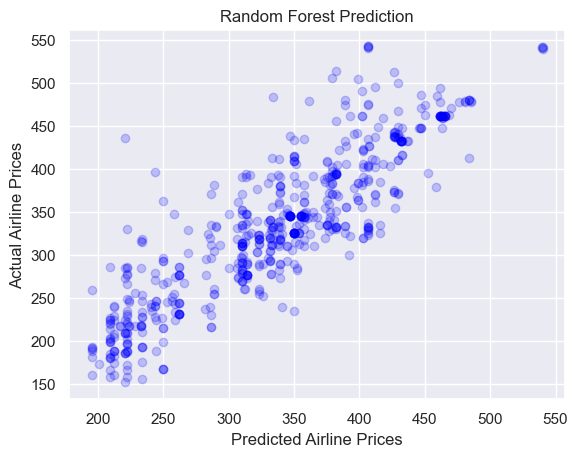

In [43]:
Random_Forest = RandomForestRegressor(random_state = 1, n_estimators = 100)
Random_Forest.fit(x_train_val, y_train_val)
get_metrics(Random_Forest)

plt.scatter(Random_Forest.predict(x_test), y_test, color = 'blue', alpha = 0.2)
plt.title('Random Forest Prediction')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices')

## Hyperparameter Tuning

In [44]:
# randomized search CV

# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]

max_features = ['auto', 'sqrt']

# Maximum level for each tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]


min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [45]:
# create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [46]:
rf_random = RandomizedSearchCV(estimator = Random_Forest, param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2)
rf_random.fit(x_train_val, y_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=400; total time=   0.4s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=400; total time=   0.5s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=400; total time=   0.4s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=400; total time=   0.4s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=400; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=900; total time=   0.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=900; total time=   0.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_e

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1),
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='neg_mean_squared_error', verbose=2)

In [47]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 10}

In [48]:
prediction = rf_random.predict(x_test)

Text(0, 0.5, 'Actual Airline Prices')

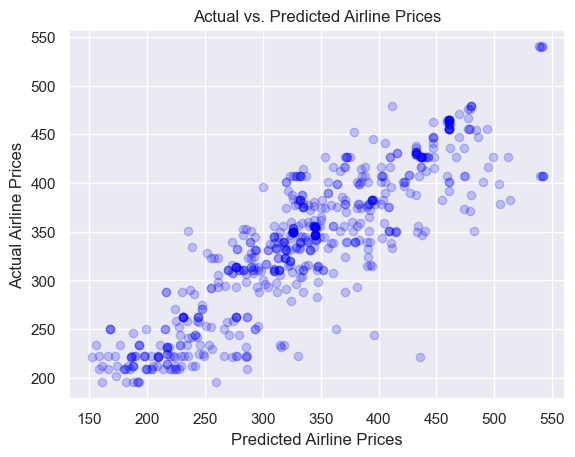

In [49]:
plt.scatter(y_test, prediction,alpha =0.2, color="Blue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices')

In [50]:
print("MAE:" , metrics.mean_absolute_error(y_test,prediction))
print("MSE:" , metrics.mean_squared_error(y_test,prediction))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,prediction)))

MAE: 30.08669925429853
MSE: 1679.2506685154378
RMSE: 40.97866113619914
